In [1]:
import jax
jax.config.update('jax_default_device',jax.devices()[-1])
jax.config.update('jax_enable_x64',True)
import equinox as eqx
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap
import optax
from diffrax import (
    diffeqsolve, ODETerm, Dopri5, ControlTerm, 
    Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, Heun,
    WeaklyDiagonalControlTerm,PIDController
)
from tqdm.auto import tqdm
from rpc_tools import pivoted_partial_cholesky
from KernelTools import get_gaussianRBF,vectorize_kfunc
from functools import partial
plt.style.use('ggplot')

In [75]:
import numpy as np
from PIL import Image as im
from matplotlib import pyplot as plt

bamdad = np.array(im.open("Bamdad.png"))[:,:,0]
jingwei = np.array(im.open("Jingwei.png"))[:,:,0]

y,x  = np.where(bamdad < 255)
y = -1 * y
bamdad = jnp.array(jnp.vstack([x,y]).T.astype(float))

y,x  = np.where(jingwei < 255)
y = -1 * y
jingwei = jnp.array(jnp.vstack([x,y]).T.astype(float))


stacked = jnp.vstack([bamdad,jingwei])
meanval = jnp.mean(stacked,axis=0)
#scale = jnp.max(jnp.abs(stacked-meanval),axis=0)
scale = jnp.std(stacked)
bamdad = (bamdad - meanval)/scale
jingwei = (jingwei - meanval)/scale


target_samples = jingwei
reference_samples = bamdad
reference_samples = jax.random.normal(jax.random.PRNGKey(138942),(100000,2))

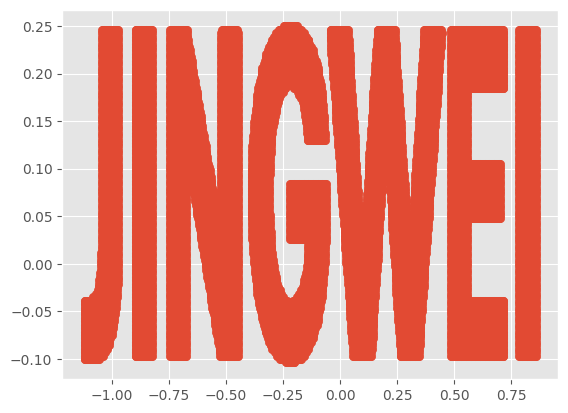

In [77]:
plt.scatter(jingwei[:,0],jingwei[:,1])

In [78]:
def sample_batch(batch_size,key):
    ref_key,target_key,normal_key,t_key = jax.random.split(key,4)
    ref_batch = jax.random.choice(ref_key,reference_samples,(batch_size,))
    target_batch = jax.random.choice(target_key,target_samples,(batch_size,))
    t_vals = jax.random.uniform(t_key,(batch_size,1))
    z = jax.random.normal(normal_key,ref_batch.shape)
    return t_vals,ref_batch,target_batch,z


def rpc_pivot(remaining,d,A,key):
    return jax.random.choice(key,remaining,p = d[remaining]/jnp.sum(d[remaining]))

def pivoted_partial_cholesky(A,k_pivots,pivoting_strategy = rpc_pivot,tol = 1e-5,seed = 203):
    N = len(A)
    k_pivots = jnp.minimum(N,k_pivots)
    d = jnp.diag(A)
    F = jnp.zeros((N,k_pivots))
    remaining_pivots = list(range(N))
    chosen_pivots = []
    trace_history = [jnp.sum(d)]
    key = jax.random.PRNGKey(seed)
    subkeys,_ = jax.random.split(key,k_pivots)

    for i in range(k_pivots):
        pivot = pivoting_strategy(remaining_pivots,d,A,subkeys[i])
        chosen_pivots.append(pivot)
        remaining_pivots.remove(pivot)
        g = A[pivot]
        g = g - F[:,:i]@F[pivot,:i].T
        F[:,i] = g/jnp.sqrt(g[pivot])
        d = d - F[:,i]**2
        d = jnp.maximum(d,0)
        trace_history.append(jnp.sum(d))

    return F,chosen_pivots,d,jnp.array(trace_history)

@jax.jit
def set_to_array(input_set):
    return jnp.array(list(input_set))


@jax.jit
def sample(key,values,probs):
    return jax.random.choice(key,values,p = probs)


def lazy_pivoted_partial_cholesky(X,k,k_pivots,tol = 1e-5,seed = 203):
    N = len(X)
    all_inds = jnp.arange(N)
    k_pivots = int(jnp.minimum(N,k_pivots))

    k_diag = jax.vmap(k,in_axes=(0,0))
    k_vec = jax.vmap(k,in_axes=(0,None))
    d = k_diag(X,X)
    F = jnp.zeros((N,k_pivots))
    
    pivot_remaining = jnp.ones(N).astype(bool)
    chosen_pivots = []

    trace_history = [jnp.sum(d)]

    key = jax.random.PRNGKey(seed)
    subkeys = jax.random.split(key,k_pivots)

    @jax.jit
    def process_pivot(F,d,pivot,i):
        g = k_vec(X,X[pivot])
        g = g - F@F[pivot]
        F = F.at[:,i].set(g/jnp.sqrt(g[pivot]))
        d = d - F[:,i]**2
        d = jnp.maximum(d,0)
        return g,F,d

    
    for i in tqdm(range(k_pivots)):
        probs = d/jnp.sum(d)
        pivot = sample(subkeys[i],all_inds,probs)
        g,F,d = process_pivot(F,d,pivot,i)

        pivot_remaining = pivot_remaining.at[pivot].set(False)
        chosen_pivots.append(pivot)
        trace_history.append(jnp.sum(d))

    return F,chosen_pivots,d,jnp.array(trace_history)

In [79]:
def I(t,x,y):
    return (1-t)*x + t * y

def It(t,x,y):
    return y-x

def self_stack(x):
    return jnp.vstack([x,x])

def gamma(t):
    return jnp.sqrt(2*t*(1-t)+1e-8)

gammadot = vmap(vmap(grad(gamma)))


def loss(b_model, t, x, y, z):
    tx = jnp.hstack([t.reshape(-1,1),I(t,x,y)+gamma(t)*z])
    bhat = jax.vmap(b_model)(tx)  # vectorise the model over a batch of data


    bnorm2 = jnp.mean(jnp.sum(bhat**2,axis=1))
    dot_term = jnp.mean(jnp.sum((It(t,x,y) + gammadot(t)*z)*bhat,axis=1))
#     dot_term = 2 * jnp.mean(jnp.sum((It(t,x,y))*bhat,axis=1))
    return bnorm2 - 2*dot_term


def get_testloader(batch_size = 1000):
    assert batch_size%2==0
    num_batches = 100
    for i in range(num_batches):
        testloader_key = jax.random.PRNGKey(1000*i)
        ref_key,target_key,normal_key,t_key = jax.random.split(testloader_key,4)

        ref_batch = jax.random.choice(ref_key,reference_samples,(batch_size,))
        target_batch = jax.random.choice(target_key,target_samples,(batch_size,))

        t_vals = jax.random.uniform(t_key,(batch_size,1))

        z = jax.random.normal(normal_key,ref_batch.shape)
        yield self_stack(t_vals),self_stack(ref_batch),self_stack(target_batch),jnp.vstack([z,-z])

def evaluate_b(b_model, testloader):
    avg_loss = 0
    for t,x,y,z in testloader:
        avg_loss += loss(b_model,t,x,y,z)
    return avg_loss / 100

In [80]:
# def test():
#     F,pivots,d,history = lazy_pivoted_partial_cholesky(t_I,k,100)

# %load_ext line_profiler
# %lprun -f lazy_pivoted_partial_cholesky test()

In [81]:
from KernelTools import get_matern_five_half, get_sum_of_kernels
from KernelTools import get_poly_kernel

t,x,y,z = sample_batch(40000,jax.random.PRNGKey(10))

Ivals = I(t,x,y)
It_vals = It(t,x,y)
t_I = jnp.hstack([t,Ivals])
k = get_sum_of_kernels([get_gaussianRBF(0.25),get_poly_kernel(deg = 4,c = 1)],[1,1])
k = get_matern_five_half(0.1)
num_pivots = 5000
F,pivots,d,history = lazy_pivoted_partial_cholesky(t_I,k,num_pivots)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [82]:
kvec = jax.vmap(k,in_axes=(0,None))
kvv = vectorize_kfunc(k)
inducing_points = t_I[jnp.array(pivots)]

batch_size = 10000
num_batches = 500

cov_mat = jnp.zeros((num_pivots,num_pivots))
rhs = jnp.zeros((num_pivots,2))

for i in tqdm(range(num_batches)):
    t,x,y,z = sample_batch(batch_size,jax.random.PRNGKey(i))
    Ivals = I(t,x,y)
    It_vals = It(t,x,y)
    t_I = jnp.hstack([t,Ivals])
    KX = kvv(t_I,inducing_points)
    cov_mat += (KX.T@KX)/num_batches
    rhs += KX.T@(It_vals+gammadot(t)*z)/num_batches

  0%|          | 0/500 [00:00<?, ?it/s]

In [83]:
coeffs = jnp.linalg.solve(cov_mat+1e-3 * jnp.identity(num_pivots),rhs)

def b_model(x):
    return jnp.dot(kvec(inducing_points,x),coeffs)

testloader = get_testloader(5000)
evaluate_b(b_model,testloader)

Array(0.18408169, dtype=float64)

In [91]:
vmapped_b_model = vmap(b_model)
@eqx.filter_jit
def dX_t(t,x,args):
    t_vec = jnp.ones((len(x),1))*t
    return vmapped_b_model(jnp.hstack([t_vec,x]))


X0 = reference_samples.copy()[:2000]


t0, t1 = 0.0,1.

solver = Dopri5()
stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)
#saveat = SaveAt(dense=True)

sol = diffeqsolve(ODETerm(dX_t), solver, t0, t1,dt0 = 0.01,  y0=X0,stepsize_controller = stepsize_controller)
#X = sol.evaluate(1.0)
#print(X)  

(-1.5, 1.5)

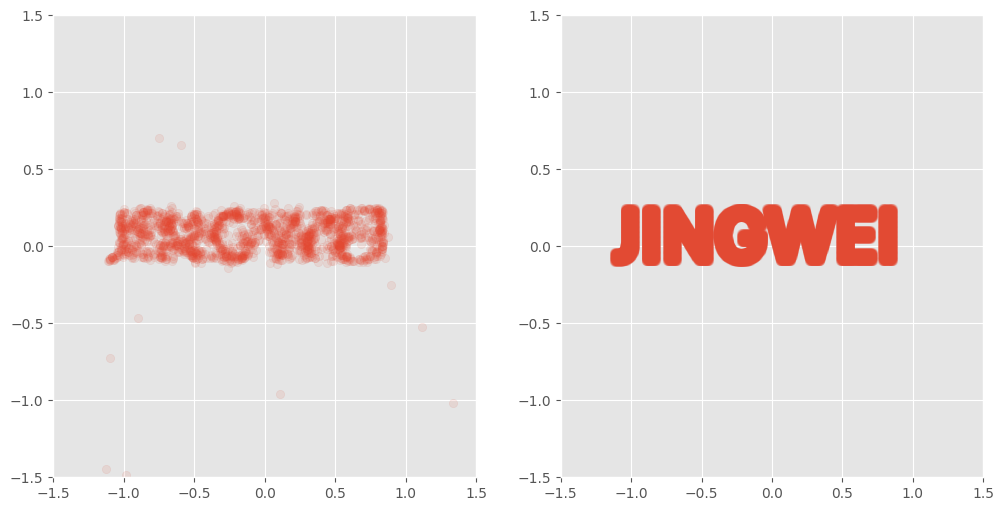

In [92]:
X = sol.ys[0]
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(X[:,0],X[:,1],alpha = 0.1)

lim = 1.5
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
plt.subplot(1,2,2)
plt.scatter(target_samples[:,0],target_samples[:,1],alpha = 0.1)
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)